In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import glob, os

In [4]:
import pandas as pd
import numpy as np
import glob, os

processed_path = r"D:\AI_Portfolio_Project\data\processed"
files = glob.glob(os.path.join(processed_path, "*.csv"))

data_dict = {}
for file in files:
    asset_name = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')  
    else:
        raise ValueError(f"{asset_name} CSV has no Date column!")
    data_dict[asset_name] = df

common_index = None
for asset, df in data_dict.items():
    if common_index is None:
        common_index = df.index
    else:
        common_index = common_index.intersection(df.index)

print("✅ Common dates count:", len(common_index))

for asset in data_dict:
    data_dict[asset] = data_dict[asset].loc[common_index]

features = ['LogReturn', 'MA_5', 'MA_21', 'Volatility_21', 'RSI']
asset_names = list(data_dict.keys())

X_all = []
for f in features:
    temp = []
    for asset in asset_names:
        temp.append(data_dict[asset][f].values)  
    temp = np.array(temp).T 
    X_all.append(temp)

X_all = np.stack(X_all, axis=2)  
print("✅ Feature tensor shape:", X_all.shape)

y_all = []
for asset in asset_names:
    y_all.append(data_dict[asset]['LogReturn'].values)
y_all = np.array(y_all).T
print("✅ Target tensor shape:", y_all.shape)


✅ Common dates count: 152
✅ Feature tensor shape: (152, 6, 5)
✅ Target tensor shape: (152, 6)


In [5]:
n_time, n_assets, n_features = X_all.shape
X_all_flat = X_all.reshape((n_time, n_assets * n_features))
print("Flattened X_all shape:", X_all_flat.shape) 


Flattened X_all shape: (152, 30)


In [25]:
lookback = 60
X, y = [], []
for t in range(lookback, len(X_all_flat)):
    X.append(X_all_flat[t-lookback:t]) 
    y.append(y_all[t])  
X = np.array(X)  
y = np.array(y)  
print("✅ Final X shape:", X.shape)
print("✅ Final y shape:", y.shape)


✅ Final X shape: (92, 60, 30)
✅ Final y shape: (92, 6)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# match your X shape: (samples, lookback, features)
sequence_length = 30  # lookback window
n_features = 30           # flattened features from all assets

inputs = layers.Input(shape=(sequence_length, n_features))

attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
x = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)
x_ffn = layers.Dense(128, activation='relu')(x)
x_ffn = layers.Dense(n_features)(x_ffn)
x = layers.LayerNormalization(epsilon=1e-6)(x_ffn + x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)

# output one value per asset (6 assets)
outputs = layers.Dense(6)(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 30, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 30)    │     31,518 │ input_layer_7[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 30, 30)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 30)    │         60 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 30, 128)   │      3,968 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 30, 30)    │      3,870 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 30, 30)    │          0 │ dense_29[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 30)    │         60 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 30)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      1,984 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 6)         │        390 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,850 (163.48 KB)

 Trainable params: 41,850 (163.48 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, y_train,
                    epochs=300,
                    batch_size=32,
                    validation_split=0.1)


Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - loss: 0.9289 - val_loss: 0.6679
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8794 - val_loss: 0.6920
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.8401 - val_loss: 0.7386
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.7763 - val_loss: 0.7811
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7923 - val_loss: 0.8455
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.8473 - val_loss: 0.9037
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.9475 - val_loss: 0.9504
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.7674 - val_loss: 0.9900
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7480 - val_loss: 1.0230
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.6968 - val_loss: 1.0589
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.7232 - val_loss: 1.1023
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.7379 - val_l

In [32]:
mse = model.evaluate(X_test, y_test)
print("Test MSE:", mse)

y_pred = model.predict(X_test)
print("Predicted shape:", y_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 4.8064
Test MSE: 4.806375503540039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted shape: (25, 6)


In [33]:
model.save("D:/AI_Portfolio_Project/results/transformer_model.h5")

print("✅ LSTM model saved in results/")


✅ LSTM model saved in results/


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


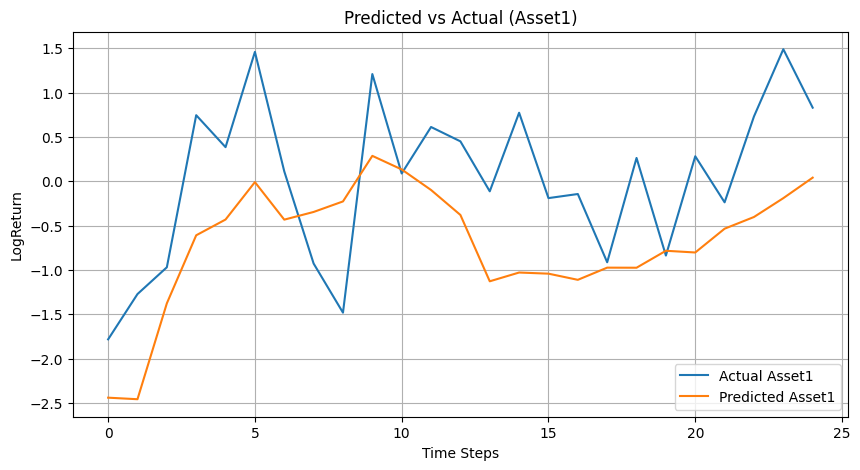

In [31]:
import matplotlib.pyplot as plt


# prediction vs actual for one asset
y_pred = model.predict(X_test)
plt.figure(figsize=(10,5))
plt.plot(y_test[:,0], label='Actual Asset1')
plt.plot(y_pred[:,0], label='Predicted Asset1')
plt.xlabel('Time Steps'); plt.ylabel('LogReturn')
plt.title('Predicted vs Actual (Asset1)')
plt.legend(); plt.grid(True); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


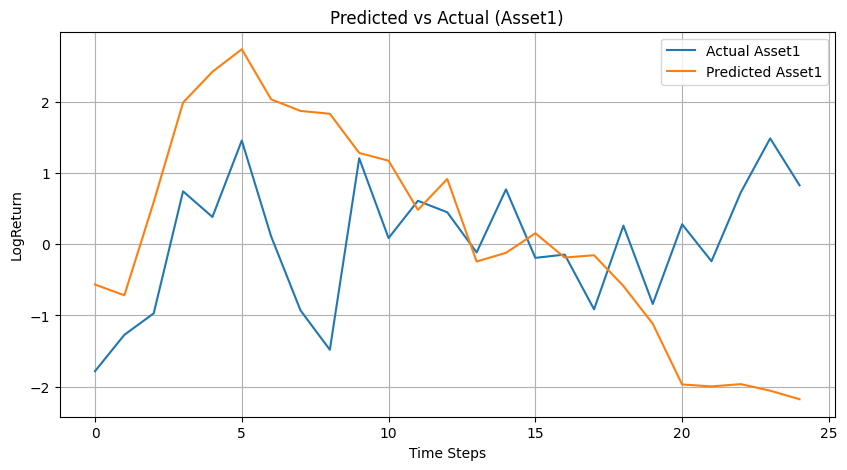

In [21]:
import matplotlib.pyplot as plt


# prediction vs actual for one asset
y_pred = model.predict(X_test)
plt.figure(figsize=(10,5))
plt.plot(y_test[:,0], label='Actual Asset1')
plt.plot(y_pred[:,0], label='Predicted Asset1')
plt.xlabel('Time Steps'); plt.ylabel('LogReturn')
plt.title('Predicted vs Actual (Asset1)')
plt.legend(); plt.grid(True); plt.show()
